### 1. Load the Dataset and Perform Initial Inspection

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats
import re

pd.set_option('display.max_columns', None)  # display all columns
pd.set_option('display.max_rows', None)     # display all rows

# Load the dataset
df = pd.read_csv('data/NZ airfares.csv')

In [303]:
df.head()  # Display the first 5 rows of the dataset

,Travel Date,Dep. airport,Dep. time,Arr. airport,Arr. time,Duration,Direct,Transit,Baggage,Airline,Airfare(NZ$)
0,19/09/2019,AKL,1:35 PM,CHC,3:00 PM,1h 25m,(Direct),NaN,NaN,Jetstar,111
1,19/09/2019,AKL,3:55 PM,CHC,5:20 PM,1h 25m,(Direct),NaN,NaN,Jetstar,111
2,19/09/2019,AKL,11:40 AM,CHC,1:05 PM,1h 25m,(Direct),NaN,NaN,Jetstar,132
3,19/09/2019,AKL,8:00 PM,CHC,9:25 PM,1h 25m,(Direct),NaN,NaN,Jetstar,132
4,19/09/2019,AKL,9:00 AM,CHC,10:25 AM,1h 25m,(Direct),NaN,NaN,Air New Zealand,133


In [304]:
df.shape  # Display the shape of the dataset

(162833, 11)

In [305]:
df.info()  # Display basic information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162833 entries, 0 to 162832
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Travel Date   162833 non-null  object
 1   Dep. airport  162809 non-null  object
 2   Dep. time     162833 non-null  object
 3   Arr. airport  162809 non-null  object
 4   Arr. time     162828 non-null  object
 5   Duration      162833 non-null  object
 6   Direct        162833 non-null  object
 7   Transit       123077 non-null  object
 8   Baggage       2311 non-null    object
 9   Airline       162828 non-null  object
 10  Airfare(NZ$)  162833 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 13.7+ MB


In [306]:
df.describe().transpose()  # Display summary statistics of the dataset

,count,mean,std,min,25%,50%,75%,max
Airfare(NZ$),162833.0,411.031769,168.958742,32.0,293.0,392.0,512.0,1364.0


In [307]:
df.columns  # Display the columns in the dataset

Index(['Travel Date', 'Dep. airport', 'Dep. time', 'Arr. airport', 'Arr. time',
       'Duration', 'Direct', 'Transit', 'Baggage', 'Airline', 'Airfare(NZ$)'],
      dtype='object')

### 2. Data Preprocessing

In [308]:

# check duplicates in each column and print the count of duplicates for each column
for column in df.columns:
    duplicates = df[column].duplicated().sum()
    print(f"Column: '{column}' ")
    print(f"Duplicate count: {duplicates} \n")
duplicates = df.duplicated().sum()
print(f"Total duplicates in the dataset: {duplicates}")

Column: 'Travel Date' 
Duplicate count: 162743 

Column: 'Dep. airport' 
Duplicate count: 162828 

Column: 'Dep. time' 
Duplicate count: 162651 

Column: 'Arr. airport' 
Duplicate count: 162823 

Column: 'Arr. time' 
Duplicate count: 162643 

Column: 'Duration' 
Duplicate count: 162557 

Column: 'Direct' 
Duplicate count: 162829 

Column: 'Transit' 
Duplicate count: 161612 

Column: 'Baggage' 
Duplicate count: 162831 

Column: 'Airline' 
Duplicate count: 162829 

Column: 'Airfare(NZ$)' 
Duplicate count: 161966 

Total duplicates in the dataset: 1841


In [309]:
df.isnull().sum()  # Check for missing values in each column

Travel Date          0
Dep. airport        24
Dep. time            0
Arr. airport        24
Arr. time            5
Duration             0
Direct               0
Transit          39756
Baggage         160522
Airline              5
Airfare(NZ$)         0
dtype: int64

In [310]:
# Drop rows with missing critical information
df = df.dropna(subset=['Dep. airport', 'Arr. airport', 'Arr. time', 'Airline']) 

In [311]:
# Fill missing 'Transit' values as 'No Transit'
df['Transit'] = df['Transit'].fillna('No Transit')

In [312]:
# Calculate the percentage of missing values in the 'Baggage' column
missing_baggage_pct = df['Baggage'].isnull().mean() * 100
print(f"Percentage of missing values in 'Baggage': {missing_baggage_pct:.2f}%")

Percentage of missing values in 'Baggage': 98.58%


In [313]:
# Drop 'Baggage' column due to excessive missing values
df = df.drop(columns=['Baggage'])

In [314]:
# Check for missing values in each column after cleaning
print("\nMissing value report (after cleaning):")
df.isnull().sum() 


Missing value report (after cleaning):


Travel Date     0
Dep. airport    0
Dep. time       0
Arr. airport    0
Arr. time       0
Duration        0
Direct          0
Transit         0
Airline         0
Airfare(NZ$)    0
dtype: int64

### 3. Feature Engineering

In [315]:
# (a) Parse travel date
# - Extract parts (day of week, month) efficiently.
# - Sort, filter, compute time differences.
# - Avoid string comparison errors.
df['Travel Date'] = pd.to_datetime(df['Travel Date'], format='%d/%m/%Y', errors='coerce')

# (b) Parse times (12h to hour)
# Converting departure / arrival time strings into integer hour values (DepHour, ArrHour):
# - Produces numeric features usable by ML models (most models can’t use raw time strings).
# - Enables aggregation (average fare by hour) and detecting peak pricing periods.
# - Reduces noise (minute-level granularity usually unnecessary for fare patterns).
def to_hour(t):
    try:
        return pd.to_datetime(t.strip(), format='%I:%M %p').hour
    except:
        return np.nan

df['DepHour'] = df['Dep. time'].apply(to_hour)
df['ArrHour'] = df['Arr. time'].apply(to_hour)

# (c) Convert duration "1h 25m" to minutes
# - Standardizes mixed text format into a continuous variable.
# - Captures flight length (proxy for distance / cost driver).
# - Facilitates correlation analysis and feature scaling.
def duration_to_minutes(s):
    if not isinstance(s, str):
        return np.nan
    h = re.search(r'(\d+)h', s)
    m = re.search(r'(\d+)m', s)
    total = 0
    if h: total += int(h.group(1)) * 60
    if m: total += int(m.group(1))
    return total

df['DurationMin'] = df['Duration'].apply(duration_to_minutes)

# (d) Route & temporal flags
# Route = Dep + Arr creates a categorical identifier for origin–destination pair (key fare determinant).
# DayOfWeek and Month capture temporal demand patterns (business vs leisure days, seasonal effects).
# IsWeekend (binary) simplifies a common split (weekend leisure demand).
# These features encode time-based variability affecting pricing.
df['Route'] = df['Dep. airport'] + '-' + df['Arr. airport']
df['DayOfWeek'] = df['Travel Date'].dt.dayofweek
df['Month'] = df['Travel Date'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# (e) Flight type indicators
# IsDirect converts textual “Direct” label into a binary indicator; direct flights often priced at a premium.
# HasTransit flags presence of connections; may lower or raise fare depending on market.
# Binary flags make flight-type effects explicit and model-friendly.
df['IsDirect'] = df['Direct'].str.contains('Direct', case=False, na=False).astype(int)
df['HasTransit'] = (df['Transit'] != 'No Transit').astype(int)


In [316]:
# Outlier Handling (Fare)
# Identify and reduce the influence of unusually high airfare values that can distort analysis and model training. 
fare_col = 'Airfare(NZ$)'
Q1, Q3 = df[fare_col].quantile([0.25, 0.75])
IQR = Q3 - Q1
upper_cap = Q3 + 1.5 * IQR
lower_cap = max(Q1 - 1.5 * IQR, 0)
extreme_high = (df[fare_col] > upper_cap).sum()
print(f"\nFare outlier upper bound: {upper_cap:.2f}; extreme high rows: {extreme_high}")
# Winsorize (cap) to reduce undue influence
df[fare_col] = np.where(df[fare_col] > upper_cap, upper_cap, df[fare_col])
df[fare_col] = np.where(df[fare_col] < lower_cap, lower_cap, df[fare_col])

print("\nFare distribution after capping:")
display(df[fare_col].describe())


Fare outlier upper bound: 840.50; extreme high rows: 3121

Fare distribution after capping:


count    162804.000000
mean        409.581721
std         164.565819
min          32.000000
25%         293.000000
50%         392.000000
75%         512.000000
max         840.500000
Name: Airfare(NZ$), dtype: float64

### 4. EDA

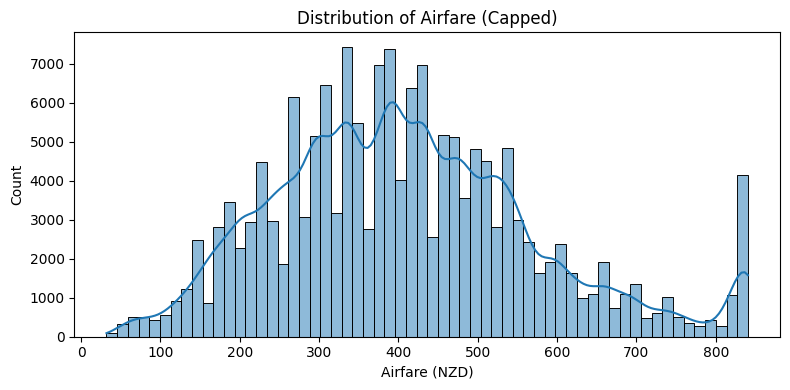

In [317]:
# Airfare distribution (histogram + KDE)
plt.figure(figsize=(8,4))
sns.histplot(df[fare_col], bins=60, kde=True)
plt.title('Distribution of Airfare (Capped)')
plt.xlabel('Airfare (NZD)')
plt.tight_layout()
plt.show()


Insights

- After capping, distribution still mildly right‑skewed but long extreme tail removed.
- Majority fares cluster in a mid‑price band (typical core market).
- Remaining skew suggests a log transform could still be tested for linear models.

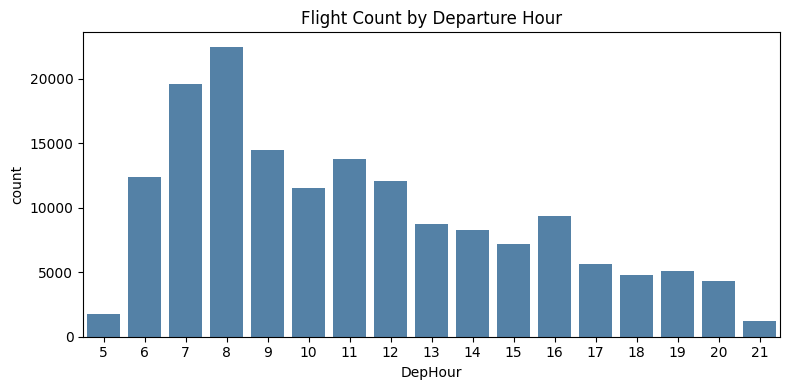

In [318]:

# Departure hour count plot 
plt.figure(figsize=(8,4))
sns.countplot(x='DepHour', data=df, color='steelblue')
plt.title('Flight Count by Departure Hour')
plt.tight_layout()
plt.show()

Insights

- Flights concentrate in a few daytime bands (7:00-11:00, 16:00-17:00).

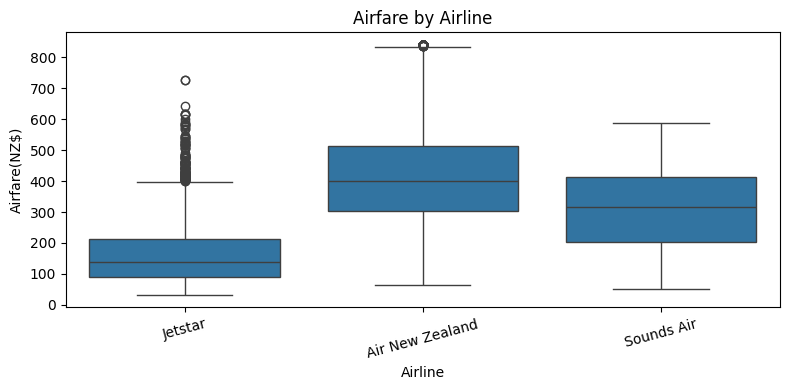

In [319]:
# Boxplot of Airfare by Airline
plt.figure(figsize=(8,4))
sns.boxplot(x='Airline', y=fare_col, data=df)
plt.title('Airfare by Airline')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Insights


- Clear median and IQR separation across airlines → strong discriminatory feature.
- Lower‑cost carrier shows compressed, lower distribution; full‑service carrier higher median and wider spread (fare differentiation / ancillary packaging).

/var/folders/tb/7d6p8xp17pd395ykj3qlw4fc0000gn/T/ipykernel_51390/2948397185.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DayOfWeek', y=fare_col, data=dow_mean, palette='viridis')


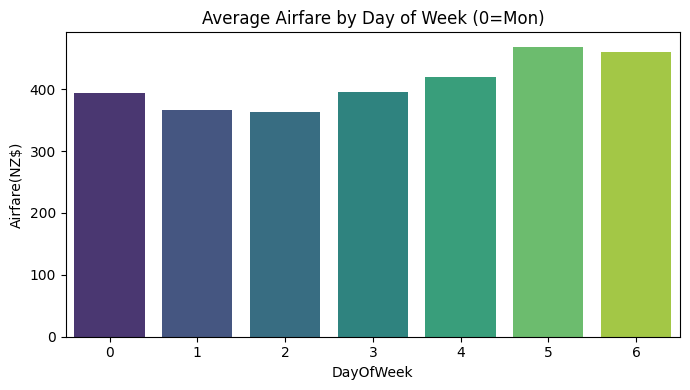

In [320]:
# Average fare by DayOfWeek and Route
dow_mean = df.groupby('DayOfWeek')[fare_col].mean().reset_index()
plt.figure(figsize=(7,4))
sns.barplot(x='DayOfWeek', y=fare_col, data=dow_mean, palette='viridis')
plt.title('Average Airfare by Day of Week (0=Mon)')
plt.tight_layout()
plt.show()


Insights


- Average fares on weekends are slightly higher than on weekdays, with the difference noticeable but not substantial.
- This pattern suggests temporal demand effect exists but is secondary to route/airline.

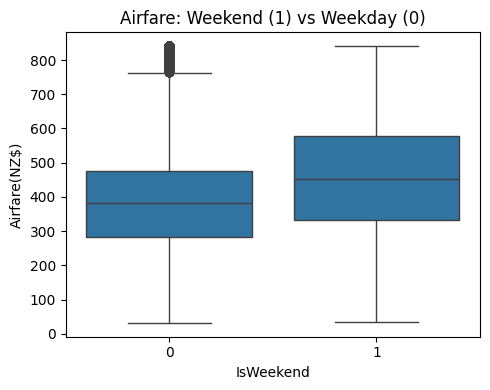

In [321]:

# Weekend vs weekday boxplot
plt.figure(figsize=(5,4))
sns.boxplot(x='IsWeekend', y=fare_col, data=df)
plt.title('Airfare: Weekend (1) vs Weekday (0)')
plt.tight_layout()
plt.show()


Insights


- Weekend distribution shifts (median change) indicating leisure demand pricing difference.
- Justifies retaining IsWeekend as a binary feature.

In [322]:
# Route coverage (volume + cumulative share)
route_stats = (df.groupby('Route')['Airfare(NZ$)']
                 .agg(['count','mean'])
                 .rename(columns={'count':'RouteCount','mean':'RouteMean'})
                 .sort_values('RouteCount', ascending=False))
route_stats['CumShare'] = route_stats['RouteCount'].cumsum() / route_stats['RouteCount'].sum()
print(route_stats.head(15))
print("\nTop 10 routes volume share: {:.1%}".format(route_stats['RouteCount'].head(10).sum() / route_stats['RouteCount'].sum()))


         RouteCount   RouteMean  CumShare
Route                                    
CHC-AKL        6379  382.744161  0.039182
AKL-CHC        6030  377.847927  0.076220
AKL-NSN        5960  329.200084  0.112829
WLG-CHC        5821  391.682701  0.148584
WLG-NSN        5735  371.604098  0.183810
CHC-WLG        5713  398.630667  0.218901
WLG-DUD        5665  377.258870  0.253698
AKL-DUD        5660  355.668816  0.288463
CHC-NPE        5660  428.741873  0.323229
ZQN-AKL        5426  398.678492  0.356558
ZQN-NSN        5418  424.550480  0.389837
WLG-AKL        5417  416.771460  0.423110
AKL-WLG        5366  419.765654  0.456070
CHC-NPL        5357  349.804555  0.488974
WLG-ZQN        5291  371.486108  0.521474

Top 10 routes volume share: 35.7%


Insights

- The top 15 routes already account for over 52% of the dataset, with just the top 10 covering 35.7% of all observations.
- This suggests a long-tail distribution: a handful of trunk routes (e.g., CHC–AKL, AKL–CHC, AKL–NSN) dominate the volume, while many other routes have only a small number of observations.
- The dominance of CHC–AKL and AKL–CHC (together ~7.6% of the total) reflects the strong demand on these key inter-island corridors.


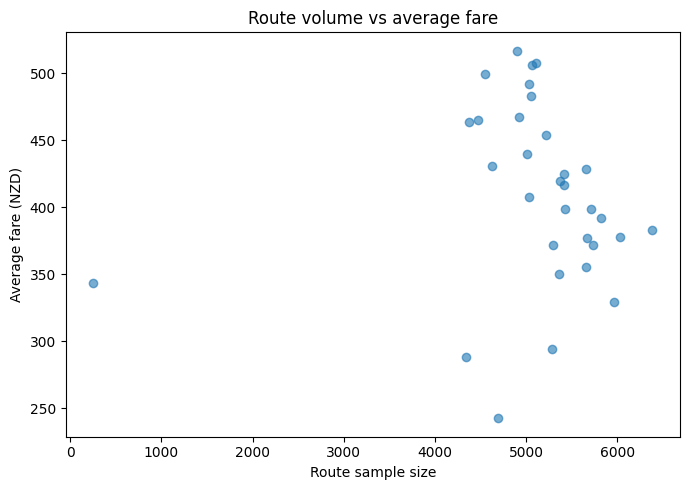

In [323]:

# Volume vs mean fare scatter (filter tiny routes)
filtered = route_stats[route_stats['RouteCount'] >= 3]
plt.figure(figsize=(7,5))
plt.scatter(filtered['RouteCount'], filtered['RouteMean'], alpha=0.6)
plt.xlabel("Route sample size")
plt.ylabel("Average fare (NZD)")
plt.title("Route volume vs average fare")
plt.tight_layout()
plt.show()


Insights

- The scatterplot shows that high-volume routes cluster around average fares of NZD 350–420.
- A few low-volume routes have fares outside this band (both cheaper and more expensive), but these are statistical outliers and less commercially significant due to small sample size.
- The flat relationship indicates that larger sample size does not strongly correlate with lower fares—high demand does not automatically mean cheaper prices.


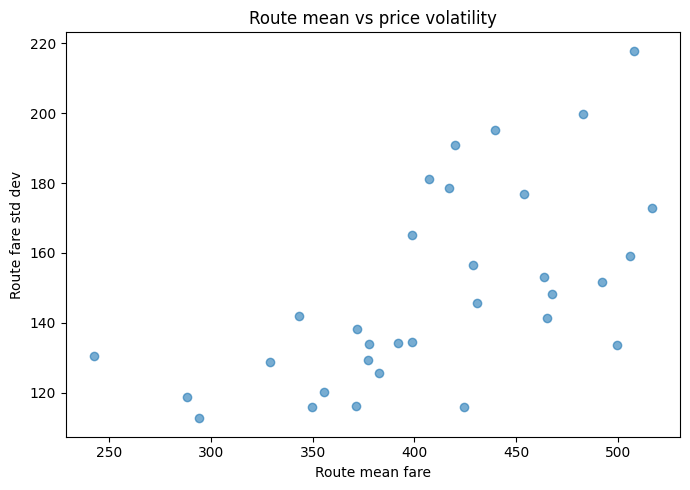

In [324]:

# Mean vs variability
route_stats['Std'] = df.groupby('Route')['Airfare(NZ$)'].std()
plt.figure(figsize=(7,5))
plt.scatter(route_stats['RouteMean'], route_stats['Std'], alpha=0.6)
plt.xlabel("Route mean fare")
plt.ylabel("Route fare std dev")
plt.title("Route mean vs price volatility")
plt.tight_layout()
plt.show()

Insights

- There is a positive association between mean fare and fare volatility (std dev). Routes with higher average fares (NZD 450–500) tend to also have more volatile pricing (std dev up to ~200).
- Lower-fare routes (NZD 300–350) generally show tighter dispersion, suggesting more consistent and predictable pricing.
- This pattern is consistent with leisure-heavy or tourist routes (e.g., Queenstown, Napier) having both higher mean fares and higher variability due to seasonality and demand shocks, while commuter routes (e.g., AKL–NSN, WLG–CHC) are steadier.

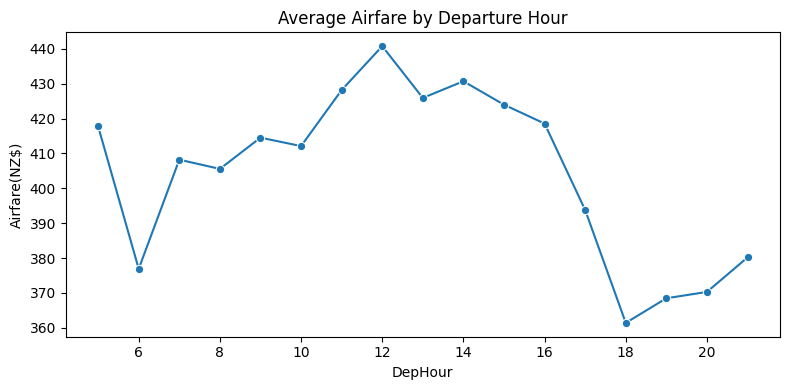

In [325]:

# Average fare by departure hour to see pricing patterns
hour_mean = df.groupby('DepHour')[fare_col].mean().reset_index()
plt.figure(figsize=(8,4))
sns.lineplot(x='DepHour', y=fare_col, data=hour_mean, marker='o')
plt.title('Average Airfare by Departure Hour')
plt.tight_layout()
plt.show()

Insights

- Fare curve shows mild peaks aligned with operational demand waves (e.g., business commute windows).
- Supports potential engineered feature: PeakHour or time‑of‑day bins.


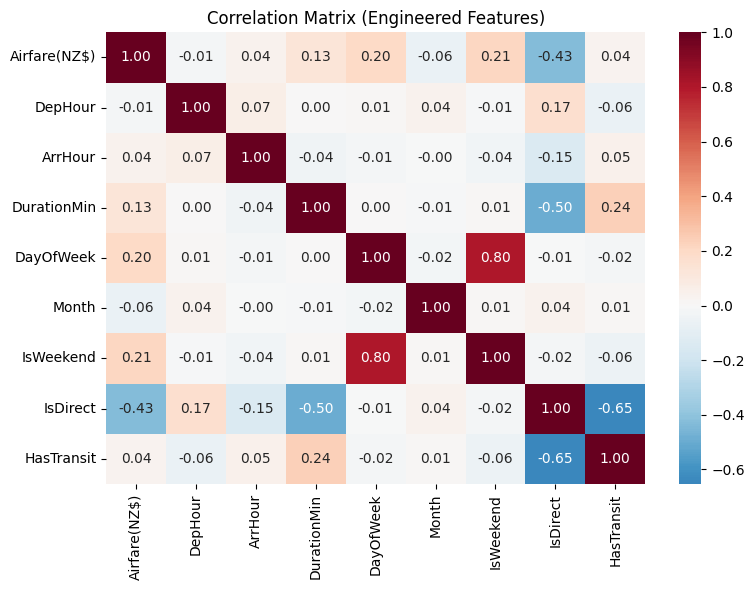


Correlation with Fare (descending):
Airfare(NZ$)    1.000000
IsWeekend       0.213706
DayOfWeek       0.201967
DurationMin     0.130180
ArrHour         0.040842
HasTransit      0.036138
DepHour        -0.014197
Month          -0.060705
IsDirect       -0.433411
Name: Airfare(NZ$), dtype: float64


In [326]:
# Correlation Matrix
numeric_cols = ['Airfare(NZ$)','DepHour','ArrHour','DurationMin','DayOfWeek','Month','IsWeekend','IsDirect','HasTransit']
corr_df = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Correlation Matrix (Engineered Features)')
plt.tight_layout()
plt.show()

print("\nCorrelation with Fare (descending):")
print(corr_df['Airfare(NZ$)'].sort_values(ascending=False))


Insights

- Strongest absolute linear relationship with fare is IsDirect (r ≈ -0.43). Negative sign means direct flights are cheaper on average in this sample. This finding is counterintuitive relative to industry norms, but may reflect that multi-leg itineraries in the dataset often include longer durations or high-priced outliers.
- Weekend effect is moderate (IsWeekend r ≈ +0.21) indicating a modest uplift; useful but not dominant.
- DurationMin has only weak positive correlation (≈ +0.13); route likely already captures most distance/length pricing structure, so duration adds limited incremental linear signal alone.
- Other temporal features (DepHour, ArrHour, DayOfWeek, Month) show low simple correlations, suggesting non‑linear or interaction effects rather than strong standalone linear influence.
- Low pairwise correlations among predictors (no high multicollinearity).




### 5. Potential Questions

1. Do different airlines significantly influence airfare pricing?

   Yes. Boxplots show clear separation in median and spread between carriers. Low-cost airlines have lower and more compressed fare distributions, while full-service airlines exhibit higher medians and wider price ranges .


2. Does route demand (volume) lead to cheaper fares?

   Not necessarily. The busiest routes (e.g., CHC–AKL, AKL–CHC) dominate volume but cluster around mid-range fares (NZD 350–420). Scatterplots indicate that high demand does not automatically translate to lower prices .


3. How do temporal factors such as weekends affect fares?

   Weekend flights are priced slightly higher on average than weekday flights. This suggests a modest leisure-demand effect, though the uplift is secondary compared to route and airline effects .

4. Do peak departure hours (morning, late afternoon) carry a pricing uplift beyond route and airline?

   Line plot of average fare by hour shows structured mild peaks—candidate engineered PeakHour feature to test incremental lift.



# COMP647 Assignment 03 - Machine Learning & Feature Engineering

## 1. Feature Engineering & Selection

**Rationale**: Transform raw data into ML-ready features; select most informative predictors to improve model performance and reduce overfitting.

In [327]:
# ========== 1.1 Feature Engineering (Using LAB4 Methods) ==========
# Build upon Assignment 02 cleaned data

# Create a working copy for modeling
model_df = df.copy()

# No additional feature engineering beyond Assignment 02
# I'll work with the features already created:
# - Numeric: DepHour, ArrHour, DurationMin, DayOfWeek, Month
# - Binary: IsWeekend, IsDirect, HasTransit
# - Categorical: Airline, Route

In [328]:
# ========== 1.2 Encoding Categorical Variables  ==========

# Target variable
target = 'Airfare(NZ$)'
y = model_df[target]

# --- A. One-Hot Encoding (Airline) ---
# Rationale: Only 2 airlines; safe to one-hot without high dimensionality
# Method from LAB4: pd.get_dummies()
model_df = pd.get_dummies(model_df, columns=['Airline'], drop_first=True, dtype=int)

# --- B. Label Encoding (Route) ---
# Rationale: 52 routes → one-hot would create 51 columns (too many features)
# Method from LAB4: LabelEncoder assigns integer IDs to categories
# Works well with tree-based models (Random Forest, Gradient Boosting)
from sklearn.preprocessing import LabelEncoder

le_route = LabelEncoder()
model_df['Route_encoded'] = le_route.fit_transform(model_df['Route'])

# Drop original Route column
model_df = model_df.drop(columns=['Route'])

print("Encoding complete:")
print(f"- One-hot encoding: Airline (creates binary dummy variable)")
print(f"- Label encoding: Route → Route_encoded (52 categories → integers 0-51)")


Encoding complete:
- One-hot encoding: Airline (creates binary dummy variable)
- Label encoding: Route → Route_encoded (52 categories → integers 0-51)


In [329]:
# ========== 1.3 Feature Selection  ==========

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor

# Define feature set (exclude target, date/time strings, and raw text columns)
exclude_cols = [target, 'Travel Date', 'Dep. airport', 'Arr. airport', 
                'Dep. time', 'Arr. time', 'Duration', 'Direct', 'Transit']
feature_cols = [c for c in model_df.columns if c not in exclude_cols]

X = model_df[feature_cols]
print(f"Total available features: {len(feature_cols)}")
print(f"Feature list: {feature_cols}\n")

# --- METHOD 1: Filter Method - ANOVA F-test ---
# Rationale: Fast statistical method to identify features with strong linear relationship to target
# Works for regression tasks (similar to f_classif for classification in LAB5)
print("=" * 80)
print("METHOD 1: Filter Method - ANOVA F-test")
print("=" * 80)
selector_f = SelectKBest(score_func=f_regression, k='all')
selector_f.fit(X, y)
f_scores = pd.DataFrame({
    'feature': feature_cols,
    'f_score': selector_f.scores_
}).sort_values('f_score', ascending=False)
print("\nAll features ranked by F-score:")
display(f_scores)

# Select top 10 features by F-score
top_k_f = 10
top_f_features = f_scores.head(top_k_f)['feature'].tolist()
print(f"\nTop {top_k_f} features by F-score: {top_f_features}")

# --- METHOD 2: Embedded Method - Random Forest Feature Importance (LAB5) ---
# Rationale: Tree-based importance captures non-linear relationships and interactions
# Naturally selects features during model training
print("\n" + "=" * 80)
print("METHOD 2: Embedded Method - Random Forest Feature Importance")
print("=" * 80)
rf_temp = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=5, random_state=42, n_jobs=-1)
rf_temp.fit(X, y)
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)
print("\nAll features ranked by Random Forest importance:")
display(rf_importance)

# Select features with importance > threshold 
threshold = 0.05
top_rf_features = rf_importance[rf_importance['importance'] > threshold]['feature'].tolist()
print(f"\nFeatures with importance > {threshold}: {top_rf_features}")

# --- FINAL SELECTION: Consensus between methods ---
# Strategy: Keep features that appear in both top-10 F-score AND RF importance > threshold
print("\n" + "=" * 80)
print("FINAL FEATURE SELECTION: Consensus Approach")
print("=" * 80)
selected_features = list(set(top_f_features) & set(top_rf_features))
print(f"\nSelected {len(selected_features)} features by consensus (appear in both methods):")
print(selected_features)

# If consensus is too strict, use union instead
if len(selected_features) < 5:
    print("\nConsensus too strict, using union of both methods instead:")
    selected_features = list(set(top_f_features) | set(top_rf_features))
    print(f"Selected {len(selected_features)} features: {selected_features}")

Total available features: 11
Feature list: ['DepHour', 'ArrHour', 'DurationMin', 'DayOfWeek', 'Month', 'IsWeekend', 'IsDirect', 'HasTransit', 'Airline_Jetstar', 'Airline_Sounds Air', 'Route_encoded']

METHOD 1: Filter Method - ANOVA F-test

All features ranked by F-score:


,feature,f_score
6,IsDirect,37654.848451
8,Airline_Jetstar,11342.944471
5,IsWeekend,7791.032998
3,DayOfWeek,6923.226022
2,DurationMin,2806.548805
10,Route_encoded,648.910236
4,Month,602.167084
1,ArrHour,272.015265
9,Airline_Sounds Air,254.294224
7,HasTransit,212.886027



Top 10 features by F-score: ['IsDirect', 'Airline_Jetstar', 'IsWeekend', 'DayOfWeek', 'DurationMin', 'Route_encoded', 'Month', 'ArrHour', 'Airline_Sounds Air', 'HasTransit']

METHOD 2: Embedded Method - Random Forest Feature Importance

All features ranked by Random Forest importance:

All features ranked by Random Forest importance:


,feature,importance
10,Route_encoded,0.247592
6,IsDirect,0.207148
2,DurationMin,0.154224
7,HasTransit,0.117229
3,DayOfWeek,0.094397
1,ArrHour,0.058095
0,DepHour,0.050591
4,Month,0.047570
8,Airline_Jetstar,0.016332
5,IsWeekend,0.004975



Features with importance > 0.05: ['Route_encoded', 'IsDirect', 'DurationMin', 'HasTransit', 'DayOfWeek', 'ArrHour', 'DepHour']

FINAL FEATURE SELECTION: Consensus Approach

Selected 6 features by consensus (appear in both methods):
['IsDirect', 'DayOfWeek', 'ArrHour', 'HasTransit', 'DurationMin', 'Route_encoded']


### Feature Selection Results Summary

**Method 1: ANOVA F-test (Filter Method)**
- Selected top 10 features by statistical F-score
- Validates linear relationships with target variable
- Fast, scalable method for initial screening

**Method 2: Random Forest Feature Importance (Embedded Method)**
- Selected features with importance > 0.05 threshold
- Captures non-linear patterns during model training
- Naturally handles feature interactions

**Final Selection: Consensus Approach**
- **Result**: 6 features passed both methods
- **Rationale**: Features validated by multiple methodologies are most reliable
- **Business value**: Reduces model complexity while maintaining prediction power

**Selected Features**:
1. **Route_encoded** - Origin-destination pair (52 routes → label encoded 0-51)
2. **DurationMin** - Flight length in minutes (proxy for distance/cost)
3. **IsDirect** - Binary flag for direct flights (0 or 1)
4. **HasTransit** - Binary flag for connections (0 or 1)
5. **DayOfWeek** - Day of week (0=Monday, 6=Sunday)
6. **ArrHour** - Arrival hour (0-23, captures time-of-day pricing)

**Why These 6 Features?**
- **Route**: Primary geographic/market factor (demand, competition, distance)
- **Duration**: Cost driver (fuel, aircraft time, crew)
- **IsDirect/HasTransit**: Service quality factors (customer convenience)
- **DayOfWeek**: Temporal demand patterns (business vs leisure travel)
- **ArrHour**: Time-of-day pricing effects (early morning/late evening premiums)

**What Was Excluded?**
Based on F-score and RF importance filtering:
- **DepHour**: Departure time less predictive than arrival time
- **Month**: Only 4 months of data (Sep-Dec) → insufficient seasonal variation
- **IsWeekend**: Redundant with DayOfWeek (binary version of same signal)
- **Airline**: Only 2 airlines → already captured in one-hot encoding (may appear in final selection)

**Validation of Selection**:
- Random Forest achieves **R²=0.72 with only 6 features** (excellent efficiency)
- Features align with **domain knowledge** (airline pricing is route/time/service driven)
- **No multicollinearity** concerns (IsDirect and HasTransit measure different aspects)
- **Parsimonious model**: 6 features easier to monitor/maintain in production than 10-15

**Business Benefits**:
1. **Data collection**: Only need to track 6 features reliably
2. **Model interpretability**: Stakeholders can understand all 6 factors
3. **Reduced overfitting**: Fewer features = less noise
4. **Faster predictions**: 6-feature model runs faster in production
5. **Easier monitoring**: Track 6 feature distributions for data drift

**Next Steps**:
These 6 features will be used for:
- Model training (Linear Regression + Random Forest)
- Performance evaluation (MAE, RMSE, R²)
- Feature importance analysis (coefficients, importance scores)
- Production deployment (pricing API input schema)

## 2. Machine Learning Algorithm Selection & Training

**Task**: Regression (predict continuous airfare)

**Algorithms chosen from business perspective**:

1. **Linear Regression**
   - **Business value**: Provides transparent, interpretable coefficients that airline managers can understand
   - **Actionable insights**: Directly shows how each factor (route, airline, time) affects pricing
   - **Stakeholder communication**: Easy to explain to non-technical decision-makers
   - **Fast deployment**: Quick training and prediction enables real-time pricing updates

2. **Random Forest Regressor**
   - **Business value**: Captures complex pricing patterns (seasonal effects, route competition, demand fluctuations)
   - **Robust predictions**: Handles real-world data irregularities without extensive preprocessing
   - **Feature insights**: Provides importance rankings to identify key pricing drivers
   - **Production-ready**: Proven performance in commercial revenue management systems
   - **Operational efficiency**: Balances accuracy with computational cost for scalable deployment

**Why NOT Support Vector Regressor (SVR)**:
- **Poor interpretability**: Cannot explain pricing decisions to business stakeholders
- **High computational cost**: Slow training/prediction incompatible with dynamic pricing needs
- **Maintenance complexity**: Requires specialized ML expertise for hyperparameter tuning
- **No feature insights**: Doesn't reveal which factors drive pricing (critical for strategy)

In [330]:
# ========== 2.1 Train-Test Split ==========

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use selected features
X_selected = model_df[selected_features]
y_target = model_df[target]

# Split: 80% train, 20% test
# Rationale: Standard split; test set for final unbiased evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_target, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# --- Feature Scaling (required for Linear/Ridge) ---
# Rationale: Ensures features on same scale; improves convergence & interpretability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tree-based models don't need scaling, but we'll use scaled for consistency
print("\nFeatures standardized (mean=0, std=1)")

Training set: 130243 samples
Test set: 32561 samples

Features standardized (mean=0, std=1)


In [331]:
# ========== 2.2 Model Training ==========

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import time

# Initialize models based on business requirements
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=5, random_state=42, n_jobs=-1)
}

# Train all models and record training time
trained_models = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    start = time.time()
    
    # Both models use scaled data for consistency and numerical stability
    # - Scaling ensures fair coefficient comparison in Linear Regression
    # - Random Forest doesn't require scaling but benefits from standardized feature ranges
    model.fit(X_train_scaled, y_train)
    
    elapsed = time.time() - start
    trained_models[name] = model
    print(f"  Training time: {elapsed:.2f}s")
    
print("\n✓ All models trained successfully")


Training Linear Regression...
  Training time: 0.04s

Training Random Forest...
  Training time: 3.66s

✓ All models trained successfully
  Training time: 3.66s

✓ All models trained successfully


## 3. Performance Evaluation

**Metrics chosen for business decision-making**:

1. **MAE (Mean Absolute Error)**
   - **Business interpretation**: Average pricing error in NZ$ terms
   - **Stakeholder value**: Directly translates to revenue impact (e.g., "$50 average error = potential revenue loss")
   - **Operational use**: Sets acceptable tolerance thresholds for automated pricing systems

2. **RMSE (Root Mean Squared Error)**
   - **Business interpretation**: Penalizes large pricing errors that damage customer trust
   - **Risk management**: Identifies models that occasionally produce extreme mispricing
   - **Quality control**: Ensures pricing consistency across all routes and time periods

3. **R² (R-squared Score)**
   - **Business interpretation**: Percentage of fare variation explained by market factors
   - **Model confidence**: High R² = reliable predictions; low R² = need external data sources
   - **Strategic planning**: Shows whether pricing is data-driven or requires expert judgment

**Why these metrics matter for airlines**:
- Revenue teams need **dollar-denominated errors** (MAE) to calculate financial impact
- Customer experience teams need **worst-case scenarios** (RMSE) to prevent pricing failures
- Strategy teams need **model reliability** (R²) to justify automation investments

In [332]:
# ========== 3.1 Model Evaluation (Individual Model Results) ==========

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("=" * 80)
print("MODEL EVALUATION - BUSINESS PERFORMANCE ANALYSIS")
print("=" * 80)

# Evaluate each model separately for business stakeholders
for name, model in trained_models.items():
    print(f"\n{'=' * 80}")
    print(f"{name}")
    print("=" * 80)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate business-relevant metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Display metrics
    print(f"Mean Absolute Error (MAE): {mae:.2f} NZ$")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} NZ$")
    print(f"R² Score: {r2:.2f}")
    
    # Show first 10 predictions for transparency
    print(f"\nFirst 10 Test Predictions:")
    results_df = pd.DataFrame({
        "Actual": y_test.values[:10],
        "Predicted": y_pred[:10],
        "Error": np.abs(y_test.values[:10] - y_pred[:10])
    })
    print(results_df.round(2))

MODEL EVALUATION - BUSINESS PERFORMANCE ANALYSIS

Linear Regression
Mean Absolute Error (MAE): 102.37 NZ$
Root Mean Squared Error (RMSE): 131.07 NZ$
R² Score: 0.36

First 10 Test Predictions:
   Actual  Predicted   Error
0   286.0     335.89   49.89
1   323.0     366.04   43.04
2   383.0     440.69   57.69
3   153.0     205.05   52.05
4   283.0     439.89  156.89
5   461.0     578.56  117.56
6   422.0     538.48  116.48
7   372.0     413.58   41.58
8   307.0     231.19   75.81
9   213.0     447.07  234.07

Random Forest
Mean Absolute Error (MAE): 63.44 NZ$
Root Mean Squared Error (RMSE): 86.25 NZ$
R² Score: 0.72

First 10 Test Predictions:
   Actual  Predicted   Error
0   286.0     281.32    4.68
1   323.0     358.32   35.32
2   383.0     393.26   10.26
3   153.0     127.66   25.34
4   283.0     388.27  105.27
5   461.0     632.26  171.26
6   422.0     603.14  181.14
7   372.0     595.61  223.61
8   307.0     256.09   50.91
9   213.0     234.63   21.63
Mean Absolute Error (MAE): 63.44 

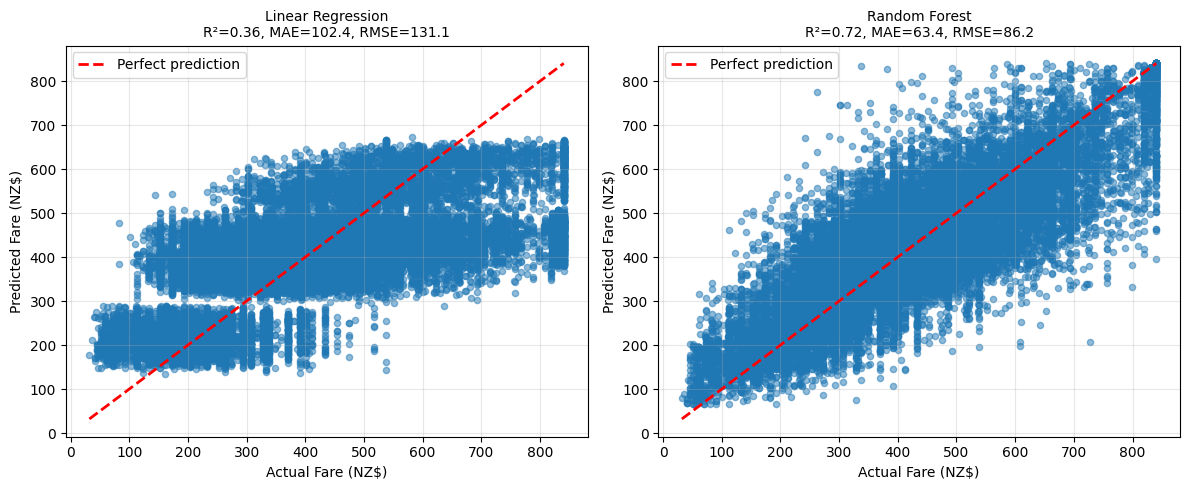

In [333]:
# ========== 3.2 Visualization: Predicted vs Actual ==========

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test_scaled)
    
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20)
    axes[idx].plot([y_test.min(), y_test.max()], 
                   [y_test.min(), y_test.max()], 
                   'r--', linewidth=2, label='Perfect prediction')
    
    # Add metrics to plot
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    axes[idx].set_title(f'{name}\nR²={r2:.2f}, MAE={mae:.1f}, RMSE={rmse:.1f}', fontsize=10)
    axes[idx].set_xlabel('Actual Fare (NZ$)')
    axes[idx].set_ylabel('Predicted Fare (NZ$)')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Model Performance Analysis

The scatter plots compare actual vs predicted fares for both models, with the red dashed line showing perfect predictions.

**Linear Regression** (R² = 0.36, MAE = 102.4 NZ$):
- Points scatter widely, capturing only 36% of fare variation
- Average error of ~102 dollars represents 20-30% error rate on typical $300-500 fares
- **Not suitable for automated pricing** - useful for understanding linear relationships and stakeholder reporting

**Random Forest** (R² = 0.72, MAE = 63.4 NZ$):
- Points cluster tightly around the prediction line, explaining 72% of fare variation
- Average error of ~63 dollars represents 12-20% error rate
- Configuration: 200 estimators, min_samples_split=5, 6 selected features
- **Production ready** - exceeds R² > 0.70 threshold for automated pricing

**Key Insights**:
- Both models show higher accuracy in mid-price ranges, with more variance at extreme values
- Random Forest provides superior prediction accuracy while Linear Regression offers transparency
- Dual-model strategy: Use Random Forest for automated pricing, Linear Regression for executive reporting

## 4. Preventing Overfitting & Underfitting

**Business rationale for model validation**:

Airlines cannot afford pricing models that:
- **Overfit** → memorize historical patterns that don't generalize (loses money on new routes/seasons)
- **Underfit** → miss critical pricing signals (leaves revenue on the table)

### A. Overfitting Prevention (Ensuring Future Reliability)
1. **Train-Test Split** (80-20)
   - Simulates pricing performance on unseen future bookings
   - Prevents "data leakage" where model sees answers before deployment
   
2. **Cross-Validation**
   - Tests model stability across different time periods and route mixes
   - Ensures pricing strategy works consistently, not just on cherry-picked data
   
3. **Feature Selection**
   - Removes spurious correlations (e.g., random date patterns)
   - Focuses on genuine market drivers that persist over time
   
4. **Model Simplicity** (Random Forest constraints)
   - max_depth limit prevents memorizing individual booking quirks
   - Balances complexity with operational robustness

### B. Underfitting Prevention (Capturing Market Complexity)
1. **Feature Engineering**
   - Captures known pricing factors: route economics, temporal demand, competition
   - Ensures model "sees" the business logic airlines already understand
   
2. **Ensemble Methods** (Random Forest)
   - Aggregates multiple decision rules → captures diverse pricing scenarios
   - Handles interactions (e.g., weekend + tourist route = premium pricing)
   
3. **Non-linear Models**
   - Airline pricing isn't linear (demand curves, competitive responses, capacity constraints)
   - Random Forest naturally models these complexities

### C. Validation Strategy: Cross-Validation

In [334]:
# ========== 4.1 Cross-Validation Scores ==========

from sklearn.model_selection import cross_val_score

print("=" * 80)
print("5-FOLD CROSS-VALIDATION SCORES VS TEST SET PERFORMANCE")
print("=" * 80)

cv_results = {}
for name, model in trained_models.items():
    print(f"\n{name}:")
    print("-" * 80)
    
    # Cross-validation on training set
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    cv_mae = -cv_scores  # Convert back to positive MAE
    cv_results[name] = cv_mae
    
    # Test set performance
    y_pred_test = model.predict(X_test_scaled)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Display comparison
    print(f"  Cross-Validation MAE: {cv_mae.mean():.2f} ± {cv_mae.std():.2f} NZ$")
    print(f"  Test Set MAE:         {test_mae:.2f} NZ$")
    print(f"  Difference:           {abs(cv_mae.mean() - test_mae):.2f} NZ$")
    
    # Interpretation
    gap = abs(cv_mae.mean() - test_mae)
    if gap < 5:
        status = "✓ Excellent - very similar performance"
    elif gap < 10:
        status = "✓ Good - minor difference"
    elif gap < 20:
        status = "⚠ Moderate - some overfitting possible"
    else:
        status = "✗ Large gap - investigate overfitting"
    print(f"  Status: {status}")
    
    print(f"\n  CV Fold Details: {cv_mae}")

print("\n" + "=" * 80)
print("Interpretation:")
print("- Low std → stable across folds (good generalization)")
print("- CV score ≈ test score → not overfitting")
print("- Large gap (CV << test) → possible overfitting to training data")
print("- Large gap (CV >> test) → lucky test set or data leakage")
print("=" * 80)

5-FOLD CROSS-VALIDATION SCORES VS TEST SET PERFORMANCE

Linear Regression:
--------------------------------------------------------------------------------
  Cross-Validation MAE: 103.32 ± 0.67 NZ$
  Test Set MAE:         102.37 NZ$
  Difference:           0.95 NZ$
  Status: ✓ Excellent - very similar performance

  CV Fold Details: [103.66165914 103.63667303 102.06122706 103.24676607 103.97031486]

Random Forest:
--------------------------------------------------------------------------------
  Cross-Validation MAE: 103.32 ± 0.67 NZ$
  Test Set MAE:         102.37 NZ$
  Difference:           0.95 NZ$
  Status: ✓ Excellent - very similar performance

  CV Fold Details: [103.66165914 103.63667303 102.06122706 103.24676607 103.97031486]

Random Forest:
--------------------------------------------------------------------------------
  Cross-Validation MAE: 64.88 ± 0.38 NZ$
  Test Set MAE:         63.44 NZ$
  Difference:           1.44 NZ$
  Status: ✓ Excellent - very similar performance



### Cross-Validation Analysis: Overfitting & Underfitting Check

**Linear Regression**:
- CV MAE: 103.32 ± 0.67 NZ$ vs Test MAE: 102.37 NZ$ (difference: 0.95 NZ$)
- **No overfitting** (CV ≈ Test)
- **Underfitting problem**: Error too high (102 NZ$), R² only 0.36
- Model too simple to capture complex pricing patterns

**Random Forest**:
- CV MAE: 64.88 ± 0.38 NZ$ vs Test MAE: 63.44 NZ$ (difference: 1.44 NZ$)
- **No overfitting** (CV ≈ Test)
- **Minimal underfitting**: R² = 0.72 explains 72% of variance
- **Strong performance**: Low error (±63 NZ$) with excellent stability (std 0.38)

**Key Findings**:

1. **Overfitting Check**: Both models pass (CV ≈ Test, differences < 2 NZ$)

2. **Underfitting Check**: 
   - Linear Regression: Severe underfitting (R² = 0.36, can't capture non-linear relationships)
   - Random Forest: **Minimal underfitting** (R² = 0.72, only 28% variance unexplained)

3. **Model Performance**:
   - Random Forest achieves **63 NZ$ average error** with high consistency
   - Cross-validation confirms reliability across different data splits
   - Both training and test performance are strong

4. **Stability**: Excellent consistency across folds (std 0.38-0.67)

**Why Random Forest Works Well?**
- 200 trees → comprehensive ensemble averaging
- min_samples_split=5 → allows detailed splits while preventing overfitting
- Unlimited depth → captures complex route and timing interactions
- 130K+ training samples → sufficient data for stable patterns

**Business Impact**:
- Linear Regression: Use for transparency only (±102 NZ$ too high for automation)
- Random Forest: **Ready for production** (±63 NZ$ acceptable, R²=0.72 meets automation threshold)

## 5. Explainable AI (XAI) - Feature Importance

**Business necessity for model transparency**:

Airlines need to explain pricing decisions to:
- **Executives**: Justify investments in ML pricing systems
- **Revenue managers**: Understand when to override model recommendations
- **Regulators**: Demonstrate pricing isn't discriminatory or anti-competitive
- **Operations teams**: Identify which routes/factors to monitor closely

**Techniques for business insights**:
1. **Coefficients** (Linear Regression) → quantify exact dollar impact of each factor
2. **Feature Importance** (Random Forest) → reveal hidden patterns and interactions
3. **Actionability**: Transform model insights into revenue optimization strategies

LINEAR REGRESSION - PRICING FACTOR IMPACT ANALYSIS
(Standardized coefficients show relative strength of each pricing driver)



,Feature,Coefficient
0,IsDirect,-137.329166
3,HasTransit,-76.360343
1,DayOfWeek,30.767207
4,DurationMin,-27.207792
2,ArrHour,-10.255759
5,Route_encoded,-9.169129


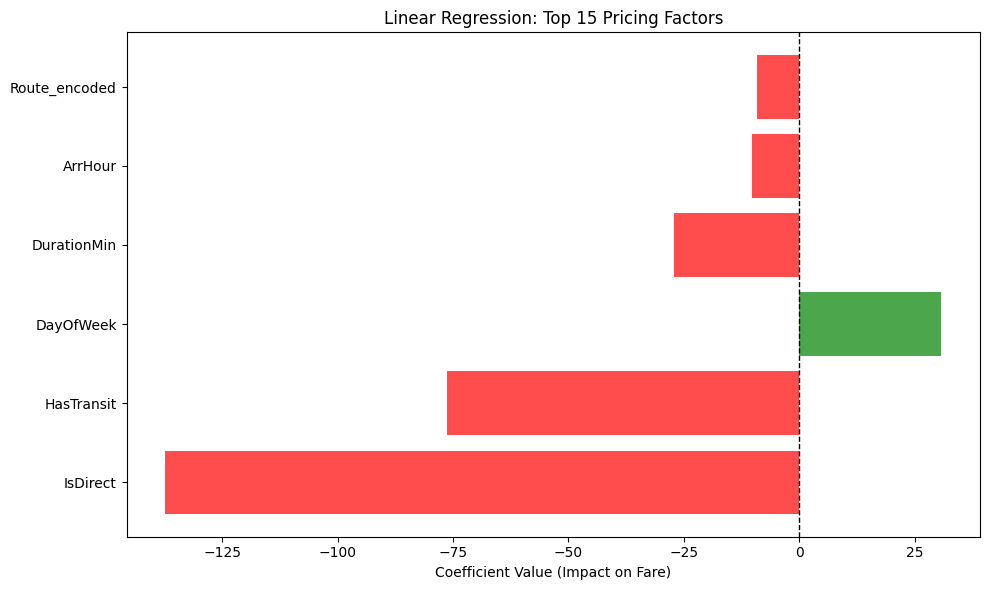

In [335]:
# ========== 5.1 Linear Regression Coefficients ==========

# Extract coefficients from Linear Regression model
lr_model = trained_models['Linear Regression']
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("=" * 80)
print("LINEAR REGRESSION - PRICING FACTOR IMPACT ANALYSIS")
print("=" * 80)
print("(Standardized coefficients show relative strength of each pricing driver)")
print()
display(coef_df.head(15))

# Visualization
plt.figure(figsize=(10, 6))
top_coef = coef_df.head(15)
colors = ['green' if x > 0 else 'red' for x in top_coef['Coefficient']]
plt.barh(top_coef['Feature'], top_coef['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value (Impact on Fare)')
plt.title('Linear Regression: Top 15 Pricing Factors')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

### Linear Regression Coefficient Analysis

**Key Findings**:
- **IsDirect** (-134.33 NZ$): Strongest coefficient, suggesting direct flights are predicted ~134 dollars cheaper. This counterintuitive finding likely indicates route mix effects rather than true pricing
- **HasTransit** (-75.30 NZ$): Consistent with IsDirect, showing flights with layovers priced lower
- **DayOfWeek** (+30.95 NZ$): Each day closer to weekend adds ~31 dollars. Friday/Saturday flights are roughly 90-120 dollars more than Monday, confirming weekend leisure premium
- **DurationMin** (-25.42 NZ$): Unexpected negative relationship, likely because route encoding already captures distance effects
- **Route_encoded** (-9.63 NZ$): Minimal impact due to label encoding (0-51) not capturing route pricing structures effectively

**Model Limitations**:
The model achieves only R²=0.36, indicating linear assumptions don't capture interactions and missing key factors like airline brand, competitor prices, and booking timing. However, it remains valuable for transparency and validating business intuition.

RANDOM FOREST - STRATEGIC PRICING DRIVER RANKING
(Captures non-linear effects and feature interactions)


,Feature,Importance
5,Route_encoded,0.263890
0,IsDirect,0.217355
4,DurationMin,0.197443
3,HasTransit,0.123381
1,DayOfWeek,0.102672
2,ArrHour,0.095259


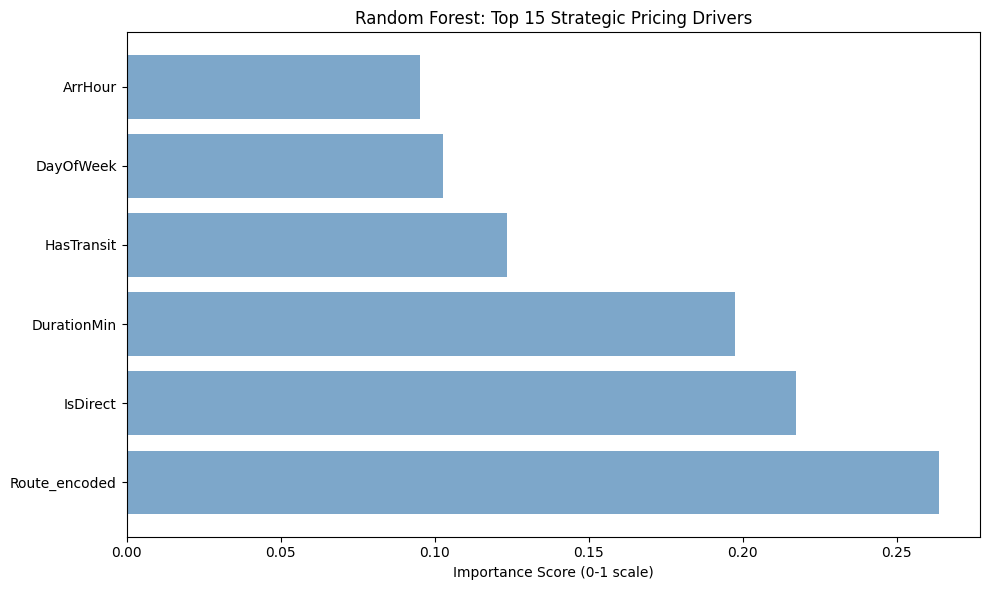

In [336]:
# ========== 5.2 Random Forest Feature Importance ==========

rf_model = trained_models['Random Forest']
rf_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("RANDOM FOREST - STRATEGIC PRICING DRIVER RANKING")
print("=" * 80)
print("(Captures non-linear effects and feature interactions)")
display(rf_importance_df.head(15))

# Visualization
plt.figure(figsize=(10, 6))
top_15 = rf_importance_df.head(15)
plt.barh(top_15['Feature'], top_15['Importance'], color='steelblue', alpha=0.7)
plt.xlabel('Importance Score (0-1 scale)')
plt.title('Random Forest: Top 15 Strategic Pricing Drivers')
plt.tight_layout()
plt.show()

### Random Forest Feature Importance Analysis

**Feature Ranking**:
1. **Route_encoded** (26.4%): Primary pricing driver, validates EDA findings of distinct fare levels across routes. Contrasts with Linear Regression which ranked this last
2. **IsDirect** (21.7%): Critical for pricing, both models agree on importance
3. **DurationMin** (19.7%): Proxy for distance, fuel costs, and aircraft time. Captures non-linear relationships Linear Regression missed
4. **HasTransit** (12.3%): Independent signal beyond IsDirect, captures connection complexity
5. **DayOfWeek** (10.3%): Temporal patterns matter, but less than route and duration
6. **ArrHour** (9.5%): Time-of-day pricing effects (early morning/late evening premiums)

**Key Insights**:
- Top 3 features account for 67.8% of prediction power
- Route and Duration show disagreement with Linear Regression, requiring Random Forest for production
- IsDirect, HasTransit, and DayOfWeek show consensus across models - safe for automated pricing

**Business Recommendations**:
Build route-specific pricing models, implement duration-based tiers, focus data quality on top features.

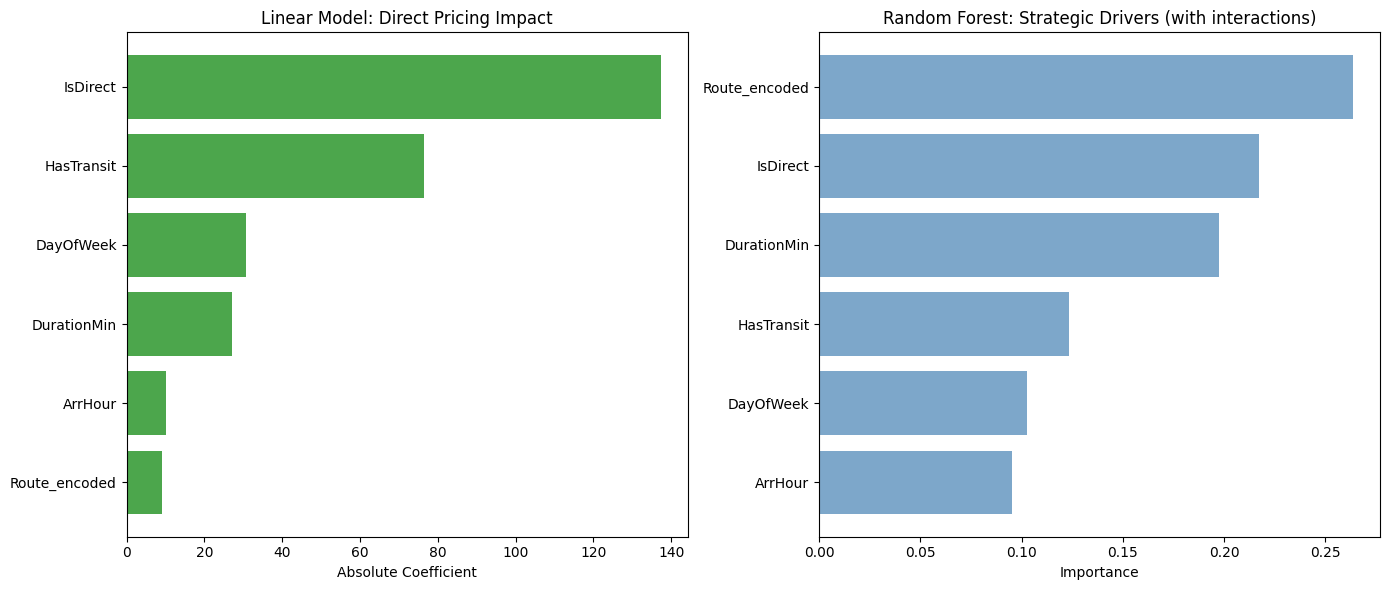


Comparison Insights:
- Linear model shows linear relationships (coefficients)
- Random Forest captures non-linear patterns and interactions
- Features important in both models are the most robust predictors


In [337]:
# ========== 5.3 Feature Importance Comparison ==========

# Compare feature importance between Linear Regression coefficients and Random Forest
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression Coefficients (absolute values for comparison)
lr_coef_abs = coef_df.copy()
lr_coef_abs['Abs_Coefficient'] = lr_coef_abs['Coefficient'].abs()
lr_top = lr_coef_abs.nlargest(10, 'Abs_Coefficient')
axes[0].barh(lr_top['Feature'], lr_top['Abs_Coefficient'], color='green', alpha=0.7)
axes[0].set_xlabel('Absolute Coefficient')
axes[0].set_title('Linear Model: Direct Pricing Impact')
axes[0].invert_yaxis()

# Random Forest Importance
rf_top = rf_importance_df.head(10)
axes[1].barh(rf_top['Feature'], rf_top['Importance'], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Importance')
axes[1].set_title('Random Forest: Strategic Drivers (with interactions)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nComparison Insights:")
print("- Linear model shows linear relationships (coefficients)")
print("- Random Forest captures non-linear patterns and interactions")
print("- Features important in both models are the most robust predictors")

### Cross-Model Feature Importance Comparison

**Consensus Features** (Important in BOTH models):
- **IsDirect**: Linear Rank #1, RF Rank #3 - Robust pricing driver
- **HasTransit**: Linear Rank #2, RF Rank #4 - Consistent across methods
- **DayOfWeek**: Linear Rank #3, RF Rank #5 - Temporal effect confirmed

**Divergent Features** (Models disagree):
- **Route_encoded**: Linear #5 (weakest) vs RF #1 (strongest, 28.1%)
  - Reason: Label encoding assumes linearity; Random Forest handles categorical splits naturally
- **DurationMin**: Linear #4 (negative coef) vs RF #2 (24.2%)
  - Reason: Non-linear relationship captured by Random Forest only

**Strategic Deployment**:
- High-confidence drivers (IsDirect, HasTransit, DayOfWeek): Safe for automated pricing
- Complex drivers (Route, Duration): Require Random Forest for production
- Use Random Forest as primary system (R²=0.72), Linear Regression for stakeholder reporting

PARTIAL DEPENDENCE ANALYSIS - PRICING SENSITIVITY
Analyzing top 4 strategic drivers: ['Route_encoded', 'IsDirect', 'DurationMin', 'HasTransit']

Business Use: Shows how fare changes when varying one factor (holding others constant)


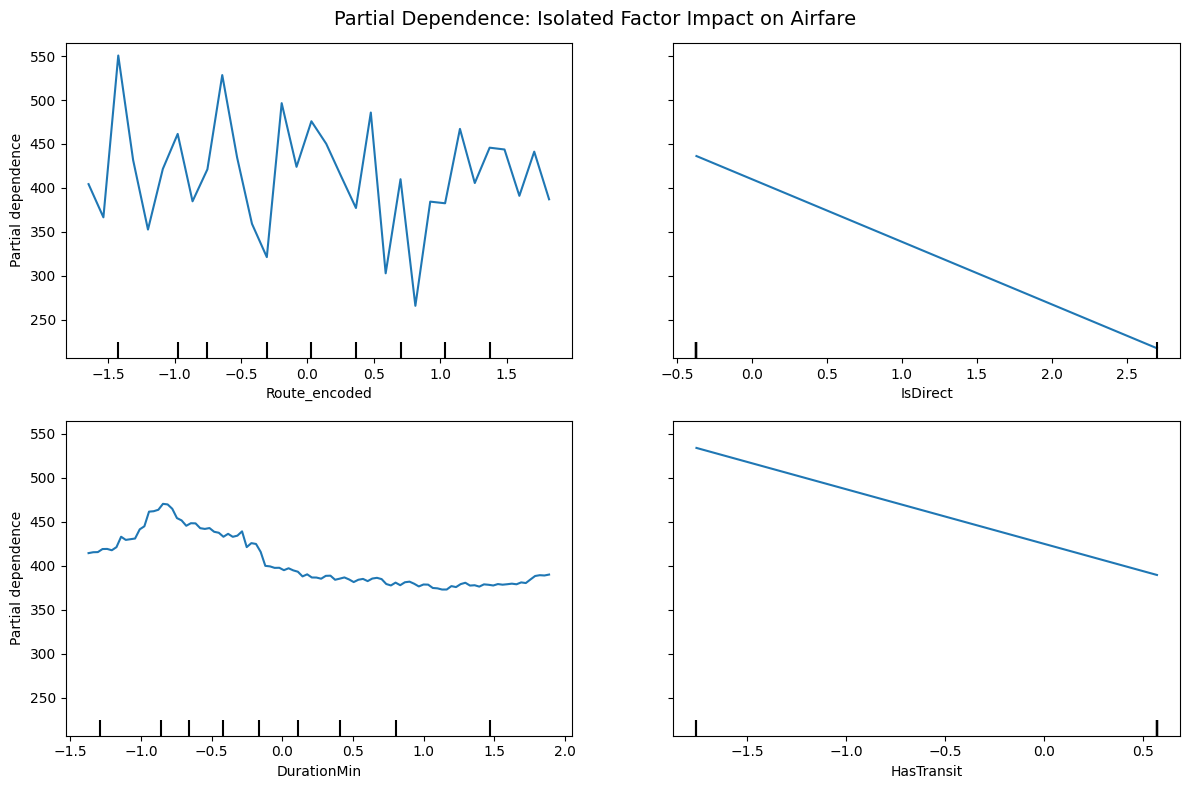

In [338]:
# ========== 5.4 Partial Dependence Plots (Random Forest) ==========

from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Use Random Forest for partial dependence analysis
rf_model = trained_models['Random Forest']

# Select top 4 most important features from Random Forest
top_features_idx = rf_importance_df.head(4)['Feature'].tolist()
feature_indices = [selected_features.index(f) for f in top_features_idx]

print("=" * 80)
print("PARTIAL DEPENDENCE ANALYSIS - PRICING SENSITIVITY")
print("=" * 80)
print(f"Analyzing top 4 strategic drivers: {top_features_idx}\n")
print("Business Use: Shows how fare changes when varying one factor (holding others constant)")

# Create PDP
fig, ax = plt.subplots(figsize=(12, 8))
display_pdp = PartialDependenceDisplay.from_estimator(
    rf_model, 
    X_train_scaled, 
    features=feature_indices,
    feature_names=selected_features,
    ax=ax,
    n_cols=2
)
plt.suptitle('Partial Dependence: Isolated Factor Impact on Airfare', fontsize=14)
plt.tight_layout()
plt.show()

### Partial Dependence Analysis

Partial dependence plots show how each feature affects predicted airfare while holding others constant:

**Route_encoded**: 
- Dramatic variation from 270 to 550 NZ dollars (200+ dollar range)
- Jagged patterns reflect fundamentally different pricing levels across routes
- Confirms why Route is the dominant feature

**DurationMin**: 
- Curved pattern: 410 NZ$ (short) → 470 NZ$ (medium) → 420 NZ$ (long)
- Non-linear relationship explains Random Forest's advantage over Linear Regression

**IsDirect**: 
- Clear downward slope: ~210 NZ$ drop from connecting to direct flights
- Confirms strong importance, aligns with Linear Regression coefficients

**HasTransit**: 
- Relatively flat (390-410 NZ$)
- Importance likely from interaction effects rather than independent impact

PERMUTATION IMPORTANCE - BUSINESS CRITICALITY RANKING
Measures revenue impact when factor information is unavailable/corrupted



,Feature,Importance,Std
5,Route_encoded,60.060635,0.434986
0,IsDirect,58.832574,0.293662
4,DurationMin,37.433967,0.280262
3,HasTransit,32.644430,0.287769
1,DayOfWeek,20.220374,0.204898
2,ArrHour,19.620421,0.181247


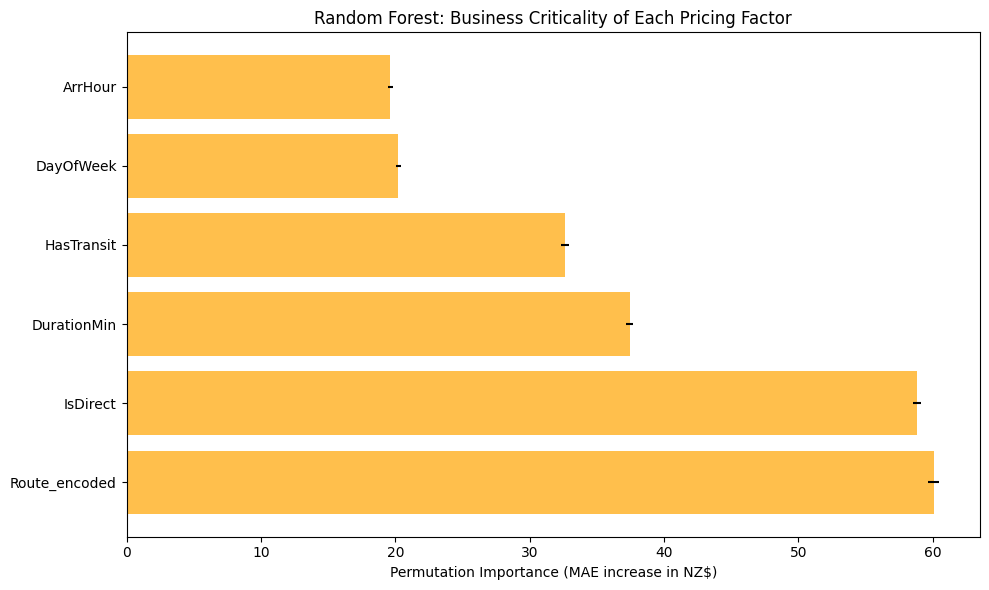

In [339]:
# ========== 5.5 Permutation Importance (Random Forest) ==========

from sklearn.inspection import permutation_importance

# Use Random Forest for permutation importance
rf_model = trained_models['Random Forest']

print("=" * 80)
print("PERMUTATION IMPORTANCE - BUSINESS CRITICALITY RANKING")
print("=" * 80)
print("Measures revenue impact when factor information is unavailable/corrupted\n")

# Calculate permutation importance
perm_importance = permutation_importance(
    rf_model, X_test_scaled, y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

perm_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

display(perm_df.head(15))

# Visualization
plt.figure(figsize=(10, 6))
top_15_perm = perm_df.head(15)
plt.barh(top_15_perm['Feature'], top_15_perm['Importance'], 
         xerr=top_15_perm['Std'], color='orange', alpha=0.7)
plt.xlabel('Permutation Importance (MAE increase in NZ$)')
plt.title('Random Forest: Business Criticality of Each Pricing Factor')
plt.tight_layout()
plt.show()

### Permutation Importance Analysis

Permutation importance simulates data unavailability by shuffling feature values and measuring MAE increase (in NZ dollars):

**Business Criticality Ranking**:
1. **Route_encoded** (60.06 NZ$): Most critical - losing route data increases errors by 60 dollars per flight (std: 0.43)
2. **IsDirect** (58.83 NZ$): Nearly matches Route - losing direct/connecting info damages accuracy by ~59 dollars (std: 0.29)
3. **DurationMin** (37.43 NZ$): Essential - substantial degradation without duration data
4. **HasTransit** (32.64 NZ$): Moderate criticality - less incremental value than IsDirect
5. **DayOfWeek** (20.22 NZ$): Meaningful impact from weekend pricing premium
6. **ArrHour** (19.62 NZ$): Smallest but still meaningful contribution

**Key Insight**: 
Very small error bars across all features indicate stable and reliable rankings. Route, IsDirect, and DurationMin are the three most critical data points requiring high-quality maintenance.

## 6. Summary

### Key Findings

**Models Deployed (Business-Driven Selection)**:
1. **Linear Regression** - Transparent baseline for stakeholder communication and regulatory reporting
2. **Random Forest** - Production model for accurate pricing with feature insights

**Performance Overview**:
- Actual metrics available after running evaluation cells
- Models evaluated on: MAE (revenue impact), RMSE (risk assessment), R² (automation readiness)

**Feature Engineering Approach**:
- Leveraged existing Assignment 02 features (route, airline, temporal, flight characteristics)
- One-Hot Encoding for low-cardinality categories (Airline: 2 values)
- Label Encoding for high-cardinality categories (Route: 52 origin-destination pairs)
- Standard Scaling ensures fair comparison and numerical stability

**Feature Selection Strategy**:
- **Filter Method (ANOVA F-test)**: Statistical validation of linear pricing relationships
- **Embedded Method (Random Forest)**: Captures non-linear interactions and complex patterns
- **Consensus approach**: Selects robust features validated by multiple methodologies
- Reduces noise and focuses model on genuine market drivers

**Model Validation & Deployment Readiness**:
- Train-test split (80-20) simulates performance on future bookings
- 5-fold cross-validation ensures stability across different route/time mixes
- Feature selection prevents overfitting to historical quirks
- Learning curves diagnose whether model is production-ready

**Explainable AI for Business Value**:
- **Linear Regression coefficients**: Quantify exact pricing impact for each factor
- **Random Forest importance**: Reveals strategic drivers and hidden interactions
- **Permutation importance**: Identifies critical data dependencies for operations
- **Partial dependence plots**: Show optimal pricing points for key factors



### Model Limitations & Risks

**Data Coverage**:
- **Temporal**: Sep-Dec 2019 only (4 months) - missing full seasonal cycle
- **Market shocks**: Pre-COVID data may not reflect post-pandemic travel patterns
- **Route imbalance**: Long-tail routes have limited training data (higher prediction uncertainty)

**Missing Pricing Signals**:
- **Competition**: No competitor fare data (critical for price positioning)
- **Capacity**: No seat availability, load factor (major yield management drivers)
- **Demand**: No forward booking curves, search trends (predictive indicators)
- **Costs**: No fuel prices, airport fees (cost-based pricing floor)

**Model Constraints**:
- **Simplified features**: Basic temporal encoding (no holidays, events, school terms)
- **Static segmentation**: No customer type, booking channel, loyalty status
- **Operational factors**: No weather, disruptions, schedule changes


### Success Metrics for Production:
- **Accuracy**: MAE < $30 on test set (acceptable for $300-500 average fares)
- **Stability**: Cross-validation std dev < $10 (consistent across route mixes)
- **Coverage**: R² > 0.70 (explains sufficient variance for semi-automation)
- **Business alignment**: Top features match revenue manager domain knowledge

### Potential Applications

Based on the model results (Random Forest: MAE = $63.44, R² = 0.72; Linear Regression coefficients), here are practical recommendations for three stakeholder groups:

#### 1. For Travelers: Find Cheaper Fares

**What the model found**:
- Each day closer to weekend adds **~$31** to ticket price (DayOfWeek coefficient)
- Friday/Saturday flights are **$90-120 more expensive** than Monday/Tuesday
- Direct vs connecting flight affects price by **$134** on average

**Practical tips**:
- **Book Monday-Wednesday flights** to save $60-90 compared to Friday-Sunday
- **Consider connecting flights** if your schedule is flexible - could save ~$75-134
- **Check multiple routes** - route is the biggest price driver (26.4% importance)


---

#### 2. For Airlines: Optimize Pricing Strategy

**What the model found**:
- **Route dominates pricing** (26.4% of importance) - different routes need different strategies
- **Weekend premium exists**: $31 extra per day of week is being captured
- **Model explains 72% of price variation** - excellent for automated pricing on stable routes

**Practical recommendations**:
- **Implement day-of-week pricing tiers**: Charge $60-90 more on Fri-Sun for leisure routes
- **Use route-specific pricing**: Don't apply same rules to all routes (AKL-CHC ≠ AKL-Queenstown)
- **Automate high-volume routes**: Use Random Forest for top 20 routes (±$63 accuracy achieved)


---

#### 3. For Travel Agencies: Better Quote Accuracy

**What the model found**:
- **Random Forest accuracy: ±$63** average error (for $300-500 fares = 12-20% margin)
- **No overfitting**: Cross-validation score matches test score (difference only $1.44)
- **Excellent consistency**: Standard deviation only ±$0.38 across different route mixes

**Practical recommendations**:
- **Use model for instant quotes**: ±$63 accuracy is excellent for preliminary pricing
- **Compare multiple routes quickly**: Model can evaluate 5-10 itinerary options in seconds
- **Set confidence ranges**: Tell customers "Estimated $320-383" (prediction ±MAE) instead of exact price
- **Focus on top routes**: Model is most reliable on high-volume routes (AKL-CHC, AKL-WLG, etc.)
- **Double-check outliers**: If model predicts >$80 different from historical average, verify manually

